In [4]:
import numpy as np
import torch

from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
sns.set(font_scale=1.3, rc={"lines.linewidth": 2.5})

In [5]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [6]:
impath = '/mnt/fs0/datasets/ImageNet21k/'
emb_path = '/mnt/fs2/bsorsch/manifold/embeddings_new/1k_objects'

# Data

In [7]:
# Wordnet tools
import pandas as pd
wordnet_wnids_labels = pd.read_csv('../manifold_old/data/words.txt', sep='\t')
wordnet_wnids_labels = wordnet_wnids_labels.to_numpy()
wordnet_wnids = wordnet_wnids_labels[:,0]
wordnet_labels = wordnet_wnids_labels[:,1]

wnids_1k = np.load(os.path.join(emb_path,'wnids_1k.npy'))

In [8]:
def label_from_wnid(wnid):
    return wordnet_labels[np.where(wordnet_wnids==wnid)[0]][0]

In [9]:
# Image preprocessing
from torchvision import transforms
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [10]:
from PIL import Image

def get_batch(i, wnid_dir, imgs, batch_size):
    xbatch = []
    for img in imgs[i*batch_size:(i+1)*batch_size]:
        try:
            x = Image.open(os.path.join(wnid_dir, img)).convert('RGB')
            xbatch.append(preprocess(x))
        except OSError: 
            pass

    return torch.stack(xbatch)

In [11]:
from torchvision.utils import make_grid
def show_grid(im_tensor, nrow=8, title=None):
    im_grid = make_grid(im_tensor, nrow=nrow, padding=2)
    im_grid = im_grid.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    im_grid = std * im_grid + mean
    im_grid = np.clip(im_grid, 0, 1)
    
    plt.figure(figsize=(15,2*len(input_tensor)//nrow))
    plt.imshow(im_grid)
    plt.axis('off')
    plt.title(title)

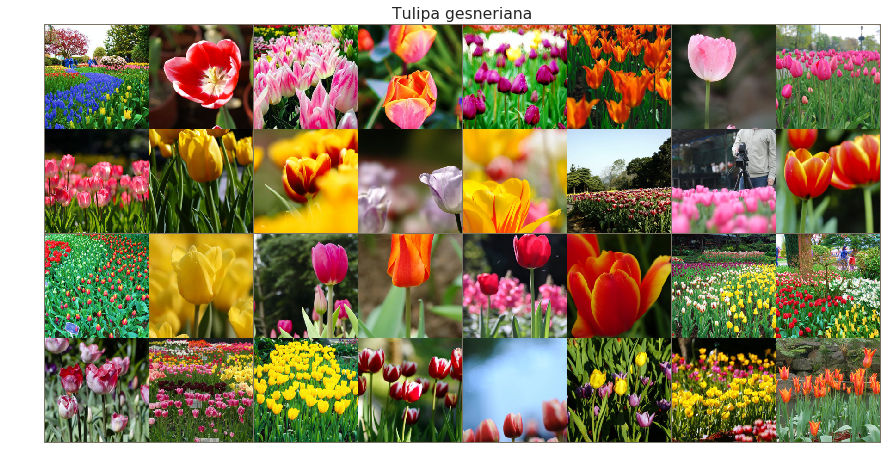

In [12]:
batch_size = 32
wnid = wnids_1k[12]
wnid_dir = os.path.join(impath, wnid)
imgs = os.listdir(wnid_dir)

input_tensor = get_batch(0, wnid_dir, imgs, batch_size)

show_grid(input_tensor, title=label_from_wnid(wnid))

# Model

In [13]:
model_name = 'resnet50'
repo = 'pytorch/vision:v0.6.0'
# repo = 'rwightman/gen-efficientnet-pytorch'
model = torch.hub.load(repo, model_name, pretrained=True)

model_dir = os.path.join(emb_path,model_name)

Using cache found in /home/bsorsch/.cache/torch/hub/pytorch_vision_v0.6.0


In [14]:
class AlexnetBackbone(torch.nn.Module):
    def __init__(self, model):
        super(AlexnetBackbone, self).__init__()
        self.N = list(model.children())[-1][-1].weight.shape[-1]
        self.pre_features = torch.nn.Sequential(*list(model.children())[:-1])
        self.features = torch.nn.Sequential(*list(model.children())[-1][:-1])
        self.flatten = torch.nn.Flatten()
        
    def forward(self, x):
        x = self.pre_features(x)
        x = self.flatten(x)
        x = self.features(x)
        return x


class SqueezeBackbone(torch.nn.Module):
    def __init__(self, model):
        super(SqueezeBackbone, self).__init__()
        self.N = list(model.children())[-1][-3].weight.shape[-1]
        self.pre_features = torch.nn.Sequential(*list(model.children())[:-1])
        self.features = torch.nn.Sequential(*list(model.children())[-1][:-1])
        self.flatten = torch.nn.Flatten()
        
    def forward(self, x):
        x = self.pre_features(x)
        x = self.features(x)
        x = self.flatten(x)
        return x


class WideResNetBackbone(torch.nn.Module):
    def __init__(self, model, module_idx):
        super(WideResNetBackbone, self).__init__()
        self.N = list(model.children())[-1].weight.shape[-1]
        self.features = torch.nn.Sequential(*list(model.children())[:-module_idx])
        self.flatten = torch.nn.Flatten()
        
    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        return x

    
class VGGBackbone(torch.nn.Module):
    def __init__(self, model, module_idx, layer_idx=None):
        super(VGGBackbone, self).__init__()
        self.module_idx = module_idx
        self.layer_idx = layer_idx
        self.pre_features = torch.nn.Sequential(*list(model.children())[:module_idx])
        if layer_idx:
            self.features = torch.nn.Sequential(*list(model.children())[module_idx][:layer_idx])
        self.flatten = torch.nn.Flatten()
        
    def forward(self, x):
        x = self.pre_features(x)
        if self.module_idx==2:
            x = self.flatten(x)
        if self.layer_idx:
            x = self.features(x)
        x = self.flatten(x)
        return x
    
    
class EfficientNetBackbone(torch.nn.Module):
    def __init__(self, model):
        super(EfficientNetBackbone, self).__init__()
        self.N = list(model.children())[-1].weight.shape[-1]
        self.pre_features = torch.nn.Sequential(*list(model.children())[:-1])
        self.flatten = torch.nn.Flatten()
        
    def forward(self, x):
        x = self.pre_features(x)
        x = self.flatten(x)
        return x

In [15]:
random_projection=True
if 'resnet' in model_name or 'resnext' in model_name:
    backbone = WideResNetBackbone(model, 1)
    random_projection=False
elif 'vgg' in model_name:
    backbone = VGGBackbone(model)
elif 'alexnet' in model_name:
    backbone = AlexnetBackbone(model)
elif 'squeeze' in model_name:
    backbone = SqueezeBackbone(model)
elif 'efficient' in model_name:
    backbone = model
    backbone.N = 1000
    random_projection=False
#     backbone = EfficientNetBackbone(model)
backbone.to('cuda').eval()

WideResNetBackbone(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0):

# Representations

In [38]:
N = 2048
P = 500
batch_size = 16

if random_projection:
    input_tensor = get_batch(0, wnid_dir, imgs, batch_size)
    U = torch.randn(backbone.N, N) / np.sqrt(N)
    U = U.cuda()

print('Getting embeddings. Saving to: ' + model_dir)
manifolds = []
for wnid in tqdm(wnids_1k):
    wnid_dir = os.path.join(impath, wnid)
    imgs = os.listdir(wnid_dir)
    
    manifold = []
    for i in range(len(imgs)//batch_size):
        input_tensor = get_batch(i, wnid_dir, imgs, batch_size)
        with torch.no_grad():
            output = backbone(input_tensor.cuda())
        if random_projection:
            manifold.append((output@U).cpu().numpy())
        else:
            manifold.append(output.cpu().numpy())
    manifold = np.concatenate(manifold)
    manifolds.append(manifold)
    
# Keep only P examples for each manifold
counts = [len(m) for m in manifolds]
# P = np.min(counts)
# manifolds = [m[:P] for m in manifolds]
# manifolds = np.stack(manifolds)
    
# # # Save dir
# if  not os.path.isdir(model_dir):
#     os.mkdir(model_dir)
# np.save(model_dir + 'manifolds.npy', manifolds)
# np.save(model_dir + 'labels.npy', labels)

Getting embeddings. Saving to: /mnt/fs2/bsorsch/manifold/embeddings_new/1k_objects/resnet50


/home/bsorsch/.tf2/lib/python3.5/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/bsorsch/.tf2/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:804: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/home/bsorsch/.tf2/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:804: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))
/home/bsorsch/.tf2/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 264 bytes but only got 252. Skipping tag 37510
  " Skipping tag %s" % (size, len(data), tag)
/home/bsorsch/.tf2/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:804: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
/home/bs

In [39]:
manifolds_stash = manifolds

In [40]:
for i in tqdm(range(len(manifolds))):
    norms = np.linalg.norm(manifolds[i],axis=-1)
    _,uniq_idxs = np.unique(norms,return_index=True)
    manifolds[i] = manifolds[i][sorted(uniq_idxs)]

In [41]:
manifolds[0].shape

(1810, 2048)

In [42]:
manifolds_stash[0].shape

(1810, 2048)

In [43]:
counts = [len(m) for m in manifolds]
np.min(counts)

729

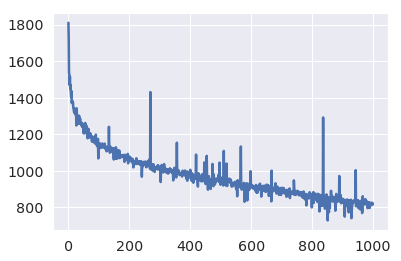

In [44]:
plt.plot(counts)

In [48]:
manifolds_old = np.load(os.path.join(model_dir,'manifolds.npy'),allow_pickle=True)

In [55]:
na = np.linalg.norm(manifolds_old[0],axis=-1)

In [59]:
np.where(na==np.linalg.norm(manifolds[0],axis=-1)[23])

(array([454]),)

In [60]:
if not os.path.isdir(model_dir):
    os.mkdir(model_dir)

# Save manifolds
np.save(os.path.join(model_dir,'manifolds.npy'),manifolds[:1000])

## Layerwise

In [20]:
class Backbone(torch.nn.Module):
    def __init__(self, model, module_idx, layer_idx=None):
        super(Backbone, self).__init__()
        self.layer_idx = layer_idx
        self.pre_features = torch.nn.Sequential(*list(model.children())[:module_idx])
        if layer_idx:
            self.features = torch.nn.Sequential(*list(model.children())[module_idx][:layer_idx])
        self.flatten = torch.nn.Flatten()
        
    def forward(self, x):
        x = self.pre_features(x)
        if self.layer_idx:
            x = self.features(x)
        x = self.flatten(x)
        return x
# backbone = WideResNetBackbone(model)
# backbone.to('cuda').eval()

In [14]:
backbone = VGGBackbone(model,2,3).cuda()

In [15]:
N = 1024
P = 500
batch_size = 10

manifolds_all = []
nmodules = len(list(model.children()))
for module_idx in tqdm(range(nmodules)):
    if module_idx != 1:
        layers = list(model.children())[module_idx]
        if np.iterable(layers):
            nlayers = len(layers)
        else:
            nlayers = 1
        for layer_idx in range(nlayers):
            lin_layer = isinstance(list(model.children())[module_idx][layer_idx],torch.nn.Linear)
            conv_layer = isinstance(list(model.children())[module_idx][layer_idx],torch.nn.Conv2d)
            if lin_layer or conv_layer:
                backbone = VGGBackbone(model,module_idx,layer_idx).cuda().eval()

                # Test batch
                wnid_dir = os.path.join(impath, wnids_1k[0])
                imgs = os.listdir(wnid_dir)
                input_tensor = get_batch(0, wnid_dir, imgs, batch_size)
                with torch.no_grad():
                    output = backbone(input_tensor.cuda())
                M = output.shape[-1]

                
                if M>1e6:
                    A = torch.randn(int(1e5),N)/np.sqrt(N)
                    A = A.cuda()
                    idxs = np.random.choice(np.arange(M),int(1e5))
                else:
                    # Construct random proj
                    A = torch.randn(M,N)/np.sqrt(N)
                    A = A.cuda()

                manifolds = []
                for wnid in tqdm(wnids_1k[:100],leave=False):
                    wnid_dir = os.path.join(impath, wnid)
                    imgs = os.listdir(wnid_dir)

                    manifold = []
                    for i in range(P//batch_size+5):
                        input_tensor = get_batch(i, wnid_dir, imgs, batch_size)
                        with torch.no_grad():
                            output = backbone(input_tensor.cuda())
                        if M>1e6:
                            manifold.append((output[:,idxs]@A).cpu().numpy())
                        else:
                            manifold.append((output@A).cpu().numpy())
                    manifold = np.concatenate(manifold)[:P]
                    manifolds.append(manifold)
                manifolds = np.stack(manifolds)
                manifolds_all.append(manifolds)

In [16]:
if not os.path.isdir(os.path.join(model_dir, 'layerwise')):
    os.mkdir(os.path.join(model_dir, 'layerwise'))

In [17]:
np.save(os.path.join(model_dir, 'layerwise','manifolds_all.npy'),manifolds_all)

# Geometry

In [7]:
manifolds_load = np.load(os.path.join(model_dir,'manifolds.npy'),allow_pickle=True)

In [8]:
P = 500
manifolds = []
for manifold in manifolds_load:
    manifolds.append(manifold[:P])
manifolds = np.stack(manifolds)

In [9]:
def compute_geometry(manifolds):
    # Radius, centers, subspaces
    Rs = []
    centers = []
    Us = []
    for manifold in tqdm(manifolds):
        center = manifold.mean(0)
        centers.append(center)
        _,R,U = np.linalg.svd(manifold - center)
        Rs.append(R[:P])
        Us.append(U[:P])
    Rs = np.stack(Rs)
    centers = np.stack(centers)
    Us = np.stack(Us)
    
    # Overlaps
    K = len(manifolds)
    ss = []
    csa = []
    csb = []
    for a in tqdm(range(K)):
        for b in range(K):
            if a!=b:
                # Center-subspace
                dx0 = centers[a] - centers[b]
                dx0hat = dx0 / np.linalg.norm(dx0)
                costheta_a = Us[a]@dx0hat
                csa.append((costheta_a**2 * Rs[a]**2).sum() / (Rs[a]**2).sum())
                costheta_b = Us[b]@dx0hat
                csb.append((costheta_b**2 * Rs[b]**2).sum() / (Rs[a]**2).sum())

                # Subspace-subspace
                cosphi = Us[a]@Us[b].T
                ss_overlap = (cosphi**2*Rs[a][:,None]**2*Rs[b]**2).sum() / (Rs[a]**2).sum()**2
                ss.append(ss_overlap)
            else:
                csa.append(np.nan)
                csb.append(np.nan)
                ss.append(np.nan)
    csa = np.stack(csa).reshape(K,K)
    csb = np.stack(csb).reshape(K,K)
    ss = np.stack(ss).reshape(K,K)
    
    return Rs, Us, centers, csa, csb, ss

In [10]:
Rs, Us, centers, csa, csb, ss = compute_geometry(manifolds)

KeyboardInterrupt: 

In [19]:
# Save geometry
np.save(os.path.join(model_dir,'Rs.npy'),Rs)
np.save(os.path.join(model_dir,'Us.npy'),Us)
np.save(os.path.join(model_dir,'centers.npy'),centers)

In [23]:
np.save(os.path.join(model_dir,'center_subspace_a.npy'),csa)
np.save(os.path.join(model_dir,'center_subspace_b.npy'),csb)
np.save(os.path.join(model_dir,'subspace_subspace.npy'),ss)

## Layerwise

In [19]:
Rs_all = []
Us_all = []
centers_all = []
csa_all = []
csb_all = []
ss_all = []
for manifolds in tqdm(manifolds_all):
    Rs, Us, centers, csa, csb, ss = compute_geometry(manifolds)
    Rs_all.append(Rs)
    Us_all.append(Us)
    centers_all.append(centers)
    csa_all.append(csa)
    csb_all.append(csb)
    ss_all.append(ss)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [20]:
np.save(os.path.join(model_dir, 'layerwise','Rs_all.npy'),Rs_all)
np.save(os.path.join(model_dir, 'layerwise','Us_all.npy'),Us_all)
np.save(os.path.join(model_dir, 'layerwise','centers_all.npy'),centers_all)
np.save(os.path.join(model_dir, 'layerwise','csa_all.npy'),csa_all)
np.save(os.path.join(model_dir, 'layerwise','csb_all.npy'),csb_all)
np.save(os.path.join(model_dir, 'layerwise','ss_all.npy'),ss_all)

(array([ 214.,  138.,  122.,  114.,  142.,  187.,  247.,  372.,  890.,
        7474.]),
 array([9.46181011e-04, 9.98437616e-02, 1.98741342e-01, 2.97638923e-01,
        3.96536503e-01, 4.95434084e-01, 5.94331665e-01, 6.93229245e-01,
        7.92126826e-01, 8.91024406e-01, 9.89921987e-01]),
 <a list of 10 Patch objects>)

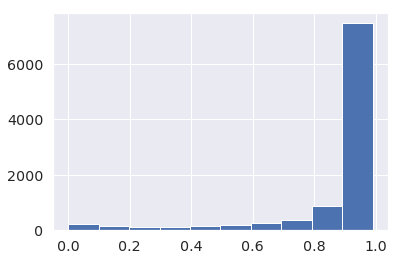

In [131]:
K= 100
mask = np.eye(K,dtype='bool')
plt.hist(csa_all_un[-1][~mask])

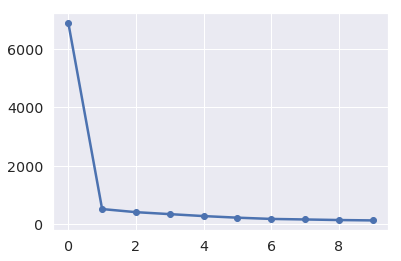

In [152]:
plt.plot(Rs_all_un[-1].mean(0)[:10], 'o-')
# plt.plot(Rs_all[-1].mean(0)/((Rs_all[-1].mean(0))).sum())
# plt.plot(Rs_all[-1][:,:400].T)
# plt.yscale('log')
# plt.xscale('log')

In [159]:
u,s,v = np.linalg.svd(manifolds_all_un[-1][0] - manifolds_all_un[-1][0].mean(0))

NameError: name 'manifolds_all_un' is not defined

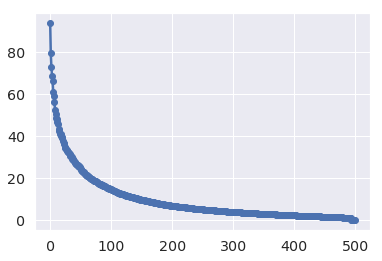

In [158]:
plt.plot(s, 'o-')

In [148]:
((Rs_all[-1].mean(0))**2).sum()**2 / ((Rs_all[-1].mean(0))**4).sum()

38.12064645077268

In [147]:
((Rs_all_un[-1].mean(0))**2).sum()**2 / ((Rs_all_un[-1].mean(0))**4).sum()

1.0452807675839613

# Generalization error

In [4]:
model_name = 'resnet50'
model_dir = os.path.join(emb_path,model_name)

In [5]:
manifolds_load = np.load(os.path.join(model_dir, 'manifolds.npy'),allow_pickle=True)

In [67]:
# P = 500
P = np.min([len(manifold) for manifold  in manifolds_load])

manifolds = []
for manifold in manifolds_load:
    manifolds.append(manifold[:P])
manifolds = np.stack(manifolds)

In [68]:
from jax import numpy as np
from jax import jit
from jax import random
key = random.PRNGKey(0)

In [79]:
m = 5

@jit
def shuffle(key,Xa,Xb):
    ''' Randomly shuffle examples in Xa and Xb along the zeroth axis.
    Args: 
        key: random PRNGkey
        Xa: (P,N) first array to shuffle
        Xb: (P,N) second array to shuffle
    
    Returns:
        Xaperm: (P,N) shuffled copy of Xa
        Xbperm: (P,N) shuffled copy of Xb
    '''
    keya,keyb=random.split(key)
    perma = random.shuffle(keya,np.arange(len(Xa)))
    permb = random.shuffle(keyb,np.arange(len(Xb)))
    
    return Xa[perma],Xb[permb]


@jit
def mshot_err(X):
    ''' Performs an m-shot learning experiment on a pair of shuffled manifolds X=(Xa,Xb).
    Args: 
        m: # training examples
        X: X=(Xa,Xb), a pair of (P,N) object manifolds, pre-shuffled along the zeroth axis.
    
    Returns:
        erra: m-shot learning error evaluated on manifold a
        errb: m-shot learning error evaluated on manifold b
    '''
    Xa,Xb = X
    xatrain, xatest = np.split(Xa, (m,))
    xa = xatrain.mean(0)
    xbtrain, xbtest = np.split(Xb, (m,))
    xb = xbtrain.mean(0)
    x = np.vstack([xa,xb])

    distsa = ((x[:,None] - xatest[None])**2).sum(-1)
    ya = distsa.argmin(0)

    distsb = ((x[:,None] - xbtest[None])**2).sum(-1)
    yb = distsb.argmin(0)

    erra = (ya!=0).mean()
    errb = (yb!=1).mean()

    return erra, errb

In [80]:
n_avg = 1

K = len(manifolds)
# P = manifolds.shape[1]
N = manifolds.shape[-1]

errs_a = []
errs_std_a = []
errs_b = []
errs_std_b = []

for a in tqdm(range(K)):
    Xa = np.array(manifolds[a])
    for b in range(a+1,K):
        Xb = np.array(manifolds[b])
        erra = []
        errb = []
        for _ in range(n_avg):
            key,_ = random.split(key)
            erratmp,errbtmp = mshot_err(shuffle(key,Xa,Xb))
            erra.append(erratmp)
            errb.append(errbtmp)
        errs_a.append(np.stack(erra).mean())
        errs_std_a.append(np.stack(erra).std())
        errs_b.append(np.stack(errb).mean())
        errs_std_b.append(np.stack(errb).std())
# errs_a = np.stack(errs_a)
# errs_std_a = np.stack(errs_std_a)
# errs_b = np.stack(errs_b)
# errs_std_b = np.stack(errs_std_b)

In [13]:
from scipy.spatial.distance import squareform

In [71]:
errs_full = np.triu(squareform(errs_a)) + np.tril(squareform(errs_b))

In [72]:
1 - np.mean(errs_full)

DeviceArray(0.9204403, dtype=float32)

In [15]:
1 - np.mean(errs_full)

DeviceArray(0.93588793, dtype=float32)

In [78]:
np.save(os.path.join(model_dir,'errs_{}shot.npy'.format(m)),errs_full)

In [44]:
# Read synset files
import pandas as pd
wnids_21k = pd.read_csv('../manifold_old/data/imagenet_synset_list.txt').to_numpy().squeeze()

In [45]:
# Wordnet tools
import pandas as pd
wordnet = np.load('../manifold_old/data/wordnet_hierarchy.npy', allow_pickle=True)
synset_wnids = pd.read_csv('../manifold_old/data/words.txt', sep='\t')
synset_wnids = synset_wnids.to_numpy()

def class_from_wnid(wnid):
    return  synset_wnids[np.where(synset_wnids==wnid)[0], 1][0]

In [47]:
# Read synset files
synset_list = pd.read_csv('../manifold_old/data/imagenet_synset_list.txt')
synset_list = synset_list.to_numpy().squeeze()

# from utils import class_from_wnid
labels_21k = np.array([class_from_wnid(wnid) for wnid in synset_list])

## Layerwise

In [6]:
model_name = 'resnet50'
model_dir = os.path.join(emb_path,model_name)

In [7]:
manifolds_all = np.load(os.path.join(model_dir, 'layerwise','manifolds_all.npy'))

In [ ]:
K = 100
err_means_all = []
err_stds_all = []
for manifolds in tqdm(manifolds_all):
    manifolds = np.stack(manifolds)
    err_means, err_stds = compute_2way_err(manifolds)
    err_means_all.append(err_means)
    err_stds_all.append(err_stds)
err_means_all = np.stack(err_means_all)
err_stds_all = np.stack(err_stds_all)

In [15]:
np.save(os.path.join(model_dir, 'layerwise','err_means_all.npy'), err_means_all)

# Theory

In [20]:
model_name = 'resnet50'
model_dir = os.path.join(emb_path,model_name)

In [142]:
errs_1shot = np.load(os.path.join(model_dir, 'errs_1shot.npy'))
# errs_5shot = np.load(os.path.join(model_dir, 'errs_5shot.npy'))

In [139]:
centers = np.load(os.path.join(model_dir,'centers.npy'))
Rs = np.load(os.path.join(model_dir,'Rs.npy'))
# Us = np.load(os.path.join(model_dir,'Us.npy'))

In [140]:
from scipy.spatial.distance import pdist, squareform
dists = squareform(pdist(centers))
dist_norm = dists / np.sqrt((Rs**2).mean(-1)[:,None])

Dsvds = np.sum(Rs**2,axis=-1)**2 / np.sum(Rs**4, axis=-1)
print('Mean Dsvd: ' + str(np.mean(Dsvds)))

Mean Dsvd: 36.286297


In [21]:
csa = np.load(os.path.join(model_dir,'center_subspace_a.npy'))
csb = np.load(os.path.join(model_dir,'center_subspace_b.npy'))
ss = np.load(os.path.join(model_dir,'subspace_subspace.npy'))

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/fs2/bsorsch/manifold/embeddings_new/1k_objects/resnet50/center_subspace_a.npy'

In [143]:
from utils import make_square
errs = make_square(errs_1shot)

In [219]:
m = 1
n_plots = 1000
K = centers.shape[0]
css = (csa + csb/m) * dist_norm[:n_plots]**2
bias = (Rs**2).sum(-1) / (Rs**2).sum(-1)[:,None] - 1
signal = dist_norm[:n_plots]**2 + bias[:n_plots]/m
noise = np.sqrt(1/Dsvds/m + 1/Dsvds/m/2 + ((Rs**2).sum(-1)/(Rs**2).sum(-1)[:,None])/Dsvds[:,None]/m/2+ css[:n_plots] + ss[:n_plots]/m)
SNR = 1/2*signal / noise

In [220]:
from scipy.special import erfc

def H(x):
    return 1/2*erfc(x/np.sqrt(2))

In [221]:
from scipy.stats import binned_statistic

In [222]:
vals, bins, binnum = binned_statistic(np.nan_to_num(SNR.ravel()), errs.ravel(), bins=100)

(0.0001, 1)

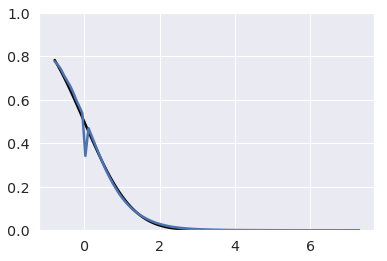

In [223]:
plt.plot(bins[1:], H(bins[1:]), c='black')
plt.plot(bins[1:],vals)
# plt.yscale('log')
# plt.xscale('log')
plt.ylim(1e-4,1)

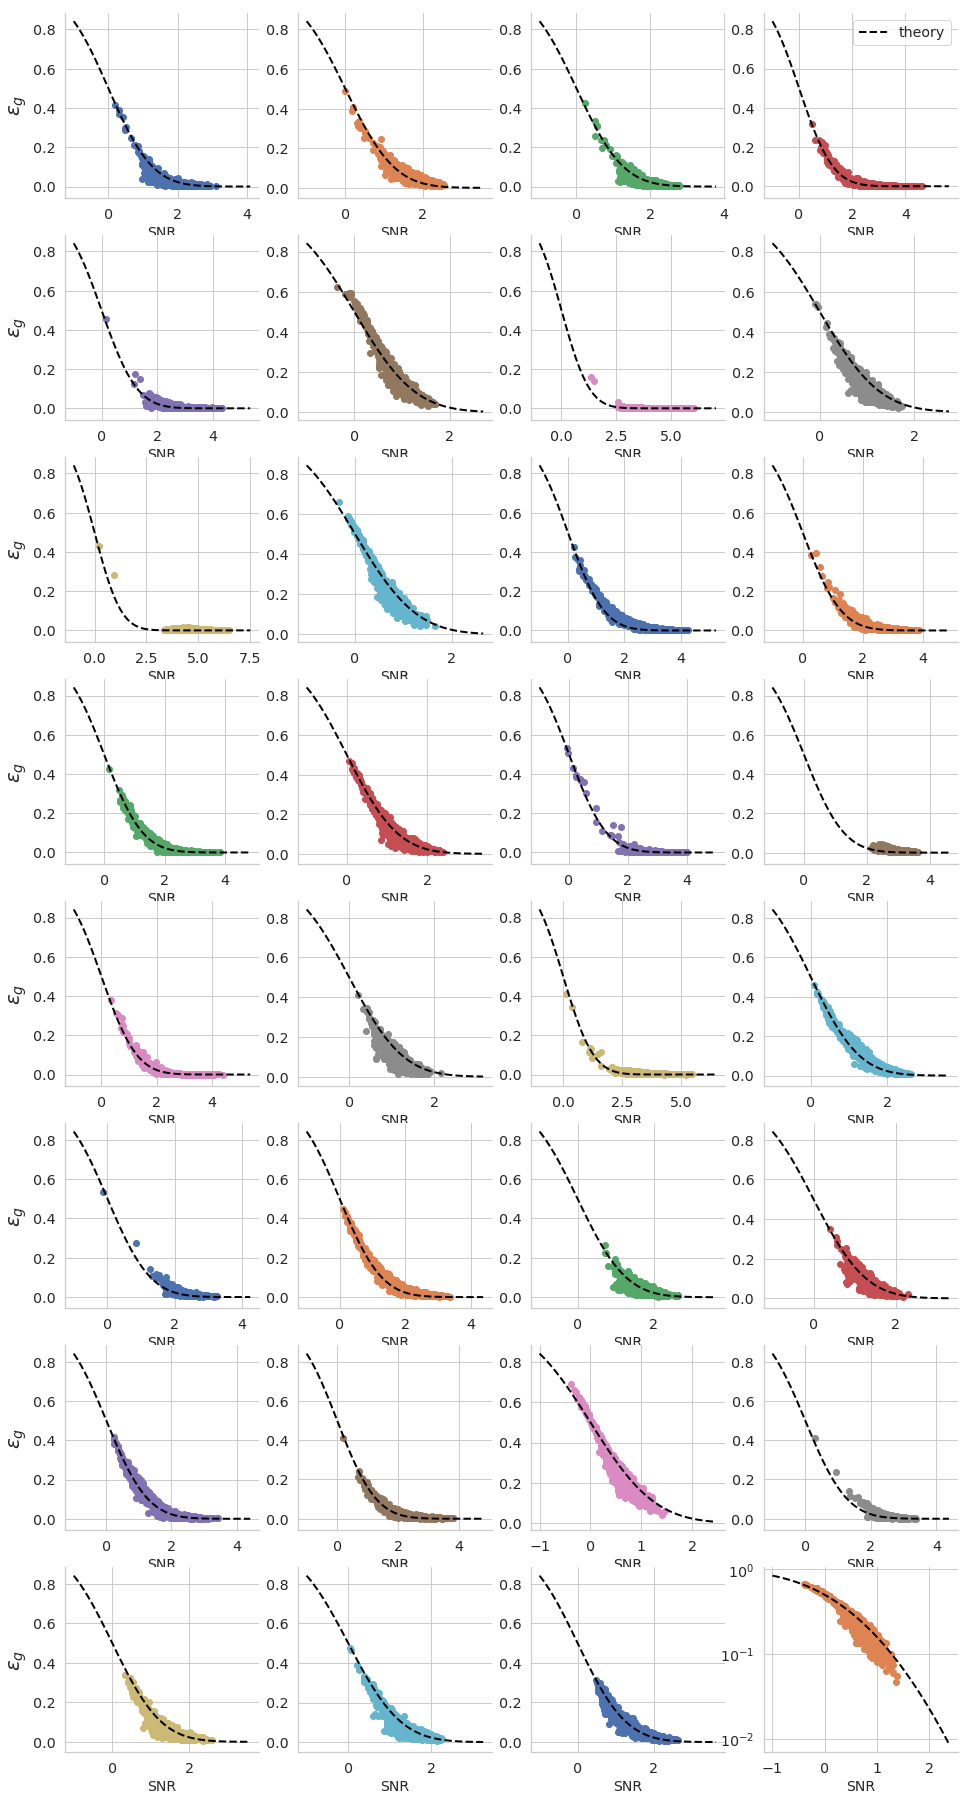

In [224]:
n_plots = 32
n_classes = 1000
with sns.axes_style('whitegrid'):    
    plt.figure(figsize=(16, n_plots//4*4))
    c = 0
    for i in range(n_plots):
        plt.subplot(n_plots//4,4,i+1)
        plt.scatter(SNR[i][np.arange(K)!=i],errs_5shot[i], c='C' + str(c%10))
        c+=1  # update color counter

        # Plot theory
        x = np.linspace(-1,np.nanmax(SNR[i])+1,50)
        plt.plot(x, H(x), c='black', linestyle='dashed', linewidth=2, label='theory')

        plt.xlabel('SNR', fontsize=14)
        if i%4==0:
            plt.ylabel(r'$\epsilon_g$', fontsize=20)
        if c==4:
            plt.legend()
        sns.despine()
plt.yscale('log')

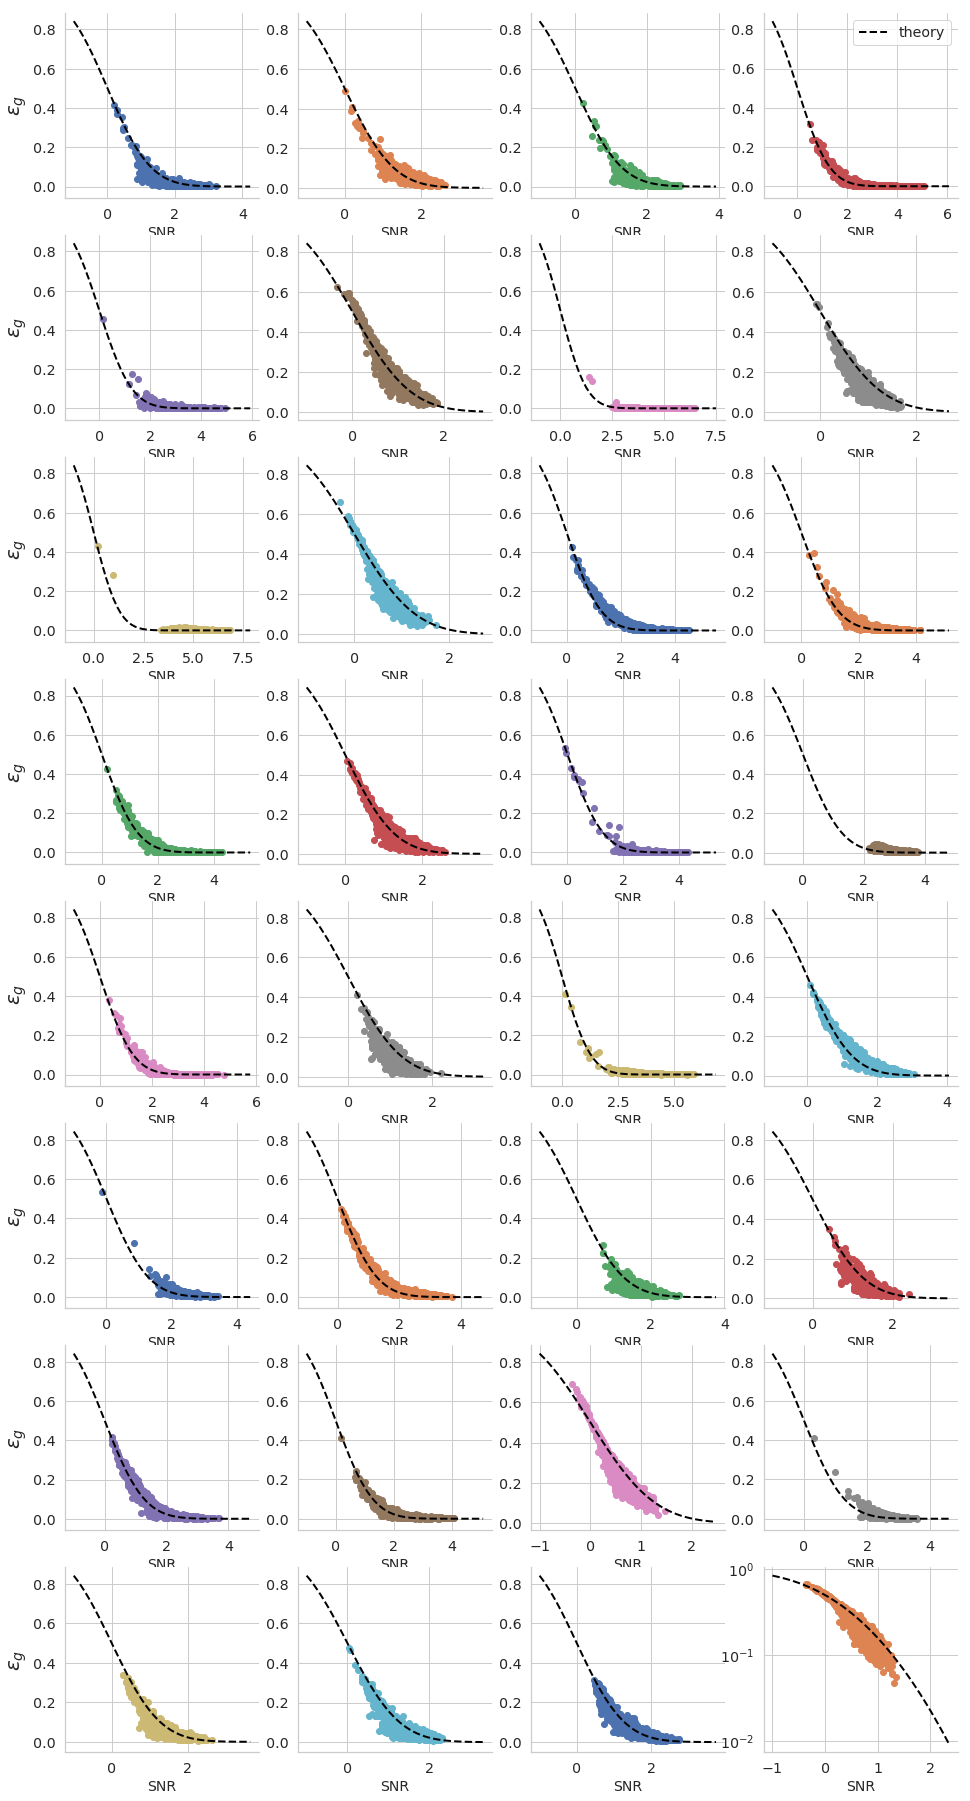

In [30]:
n_plots = 32
n_classes = 1000
with sns.axes_style('whitegrid'):    
    plt.figure(figsize=(16, n_plots//4*4))
    c = 0
    for i in range(n_plots):
        plt.subplot(n_plots//4,4,i+1)
        plt.scatter(SNR[i][np.arange(K)!=i],errs_5shot[i], c='C' + str(c%10))
        c+=1  # update color counter

        # Plot theory
        x = np.linspace(-1,np.nanmax(SNR[i])+1,50)
        plt.plot(x, H(x), c='black', linestyle='dashed', linewidth=2, label='theory')

        plt.xlabel('SNR', fontsize=14)
        if i%4==0:
            plt.ylabel(r'$\epsilon_g$', fontsize=20)
        if c==4:
            plt.legend()
        sns.despine()
plt.yscale('log')

# Layerwise geometry

In [ ]:
err_mea

In [25]:
from scipy.spatial.distance import pdist,squareform
root = '/mnt/fs2/bsorsch/manifold/embeddings_new/1k_objects/'
err_root = '/mnt/fs2/bsorsch/manifold/embeddings/1k_objects/'

def load_geometry(modelname, m):
    model_dir = os.path.join(root,modelname)
    Rs_all = np.load(os.path.join(model_dir, 'layerwise','Rs_all.npy'),)
    centers_all = np.load(os.path.join(model_dir, 'layerwise','centers_all.npy'),)
    csa_all = np.load(os.path.join(model_dir, 'layerwise','csa_all.npy'),)
    csb_all = np.load(os.path.join(model_dir, 'layerwise','csb_all.npy'),)
    ss_all = np.load(os.path.join(model_dir, 'layerwise','ss_all.npy'),)
    err_all = np.load(os.path.join(model_dir, 'layerwise','err_means_all.npy'),)

    Ds_all = (Rs_all**2).sum(-1)**2 / (Rs_all**4).sum(-1)
    dist_norms = []
    SNRs = []
    for centers,Rs,Ds,ss,csa,csb in zip(centers_all,Rs_all,Ds_all,ss_all,csa_all,csb_all):
        dists = squareform(pdist(centers))
        dist_norm = dists / np.sqrt((Rs**2).mean(-1)[:,None])
        dist_norms.append(dist_norm)

        css = (csa + csb/m) * dist_norm**2
        bias = (Rs**2).sum(-1) / (Rs**2).sum(-1)[:,None] - 1
        SNR = 1/2*(dist_norm**2 + bias/m)/ np.sqrt(1/Ds/m + css + ss/m)
        SNRs.append(SNR)
    dist_norms = np.stack(dist_norms)
    SNRs = np.stack(SNRs)
    
    return SNRs,dist_norms,Ds_all,csa_all,err_all

In [127]:
modelname='resnet50_untrained'
model_dir = os.path.join(root,modelname)
# manifolds_all_un = np.load(os.path.join(model_dir, 'layerwise','manifolds_all.npy'),)
ss_all = np.load(os.path.join(model_dir, 'layerwise','ss_all.npy'),)

In [139]:
ss_all.shape

(22, 100, 100)

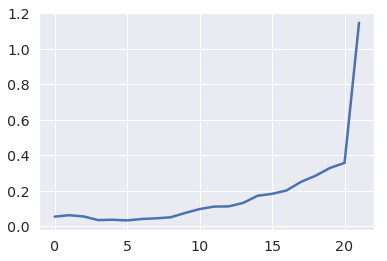

In [140]:
plt.plot(np.nanmean(ss_all,(1,2)));

In [121]:
manifolds = manifolds_all_un[-1]

In [122]:
manifolds.shape

(100, 500, 1024)

In [123]:
M = manifolds.reshape(-1,1024)

In [124]:
U,S,V = np.linalg.svd(M,full_matrices=False)

In [126]:
S.shape

(1024,)

In [137]:
M = (U[:,1:]*S[1:]@V[1:])

In [138]:
M = M.reshape(100,500,1024)

In [125]:
U.shape

(50000, 1024)

In [26]:
m = 5
SNR_un,dist_norm_un,Ds_un,csa_un,err_all_un = load_geometry('resnet50_untrained', m)
SNR_50,dist_norm_50,Ds_50,csa_50,err_all_50 = load_geometry('resnet50', m)
SNR_152,dist_norm_152,Ds_152,csa_152,err_all_152 = load_geometry('resnet152', m)
SNR_vgg,dist_norm_vgg,Ds_vgg,csa_vgg,err_all_vgg = load_geometry('vgg19', m)

In [27]:
from scipy.special import erfc

def H(x):
    return erfc(x/np.sqrt(2))/2

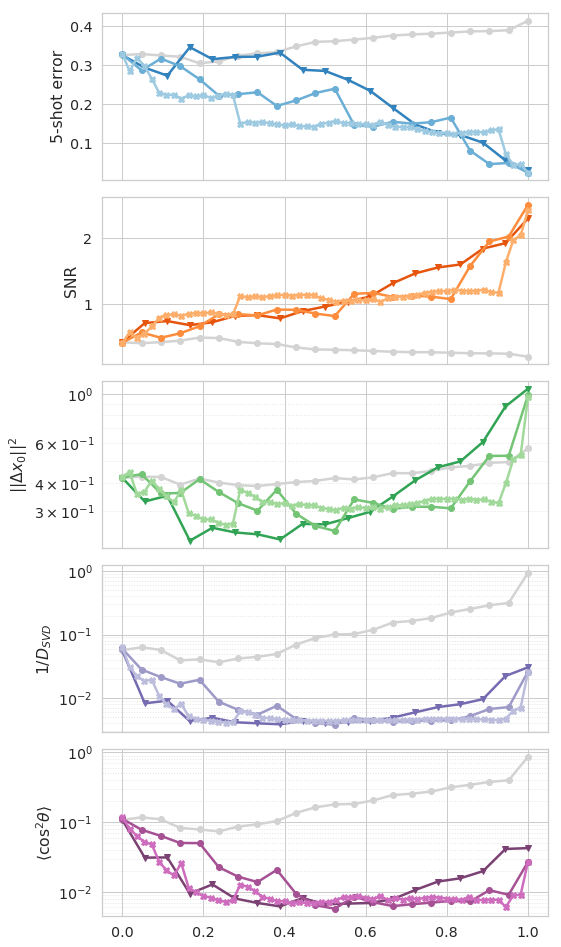

In [33]:
xrn = np.arange(len(Ds_50)) / (len(Ds_50)-1)
x_vgg = np.arange(len(Ds_vgg))*(len(Ds_50)-1)/(len(Ds_vgg)-1) / (len(Ds_50)-1)
xrn152 = np.arange(len(Ds_152))*(len(Ds_50)-1)/(len(Ds_152)-1) / (len(Ds_50)-1)

m = 1
K = 100
mask = np.eye(K,dtype='bool')
cm = sns.color_palette('tab20c')
sns.set_style('whitegrid')
fig = plt.figure(figsize=(8,20))
fmt_vgg = 'v-'
fmt_rn50 = 'o-'
fmt_rn152 = 'X-'

# Error
ax = plt.subplot(611)
plt.plot(xrn,err_all_un.mean((1,2)), fmt_rn50, c='lightgrey', label='Untrained')
plt.plot(x_vgg,err_all_vgg.mean((1,2)), fmt_vgg, c=cm[0], label='VGG19')
plt.plot(xrn,err_all_50.mean((1,2)), fmt_rn50, c=cm[1], label='ResNet50')
plt.plot(xrn152,err_all_152.mean((1,2)), fmt_rn152, c=cm[2], label='ResNet152')
plt.ylabel('5-shot error')
# plt.yscale('log')
ax.xaxis.set_ticklabels([]);

# SNR
ax2 = plt.subplot(612)
plt.plot(xrn,SNR_un[:,~mask].mean(-1), fmt_rn50, c='lightgrey', label='Untrained')
plt.plot(x_vgg,SNR_vgg[:,~mask].mean(-1), fmt_vgg, c=cm[0+4], label='VGG19')
plt.plot(xrn,SNR_50[:,~mask].mean(-1), fmt_rn50, c=cm[1+4], label='ResNet50')
plt.plot(xrn152,SNR_152[:,~mask].mean(-1), fmt_rn152, c=cm[2+4], label='ResNet152')
plt.ylabel('SNR')
# plt.yscale('log')
ax2.xaxis.set_ticklabels([]);

# Distance
ax3 = plt.subplot(613)
plt.plot(xrn,dist_norm_un[:,~mask].mean(-1), fmt_rn50, c='lightgrey', label='Untrained')
plt.plot(x_vgg,dist_norm_vgg[:,~mask].mean(-1), fmt_vgg, c=cm[0+8], label='VGG19')
plt.plot(xrn,dist_norm_50[:,~mask].mean(-1), fmt_rn50, c=cm[1+8], label='ResNet50')
plt.plot(xrn152,dist_norm_152[:,~mask].mean(-1), fmt_rn152, c=cm[2+8], label='ResNet152')
plt.ylabel(r'$||\Delta x_0||^2$')
plt.yscale('log')
ax3.xaxis.set_ticklabels([]);

# Dimension
ax4 = plt.subplot(614)
plt.plot(xrn,1/Ds_un.mean(-1), fmt_rn50, c='lightgrey', label='Untrained')
plt.plot(x_vgg,1/Ds_vgg.mean(-1), fmt_vgg, c=cm[0+12], label='VGG19')
plt.plot(xrn,1/Ds_50.mean(-1), fmt_rn50, c=cm[1+12], label='ResNet50')
plt.plot(xrn152,1/Ds_152.mean(-1), fmt_rn152, c=cm[2+12], label='ResNet152')
plt.ylabel(r'$1/D_{SVD}$')
plt.yscale('log')
ax4.xaxis.set_ticklabels([]);

# Center-subspace
ax5 = plt.subplot(615)
cm = sns.color_palette('tab20b')
plt.plot(xrn,csa_un[:,~mask].mean(-1), fmt_rn50, c='lightgrey', label='Untrained')
plt.plot(x_vgg,csa_vgg[:,~mask].mean(-1), fmt_vgg, c=cm[0+16], label='VGG19')
plt.plot(xrn,csa_50[:,~mask].mean(-1), fmt_rn50, c=cm[1+16], label='ResNet50')
plt.plot(xrn152,csa_152[:,~mask].mean(-1), fmt_rn152, c=cm[2+16], label='ResNet152')
plt.ylabel(r'$\langle \cos^2\theta\rangle$')
plt.yscale('log')

# Major ticks every 20, minor ticks every 5
major_ticks = np.arange(0, len(Ds_152), 5)
minor_ticks = np.arange(0, len(Ds_152))

# And a corresponding grid
ax2.grid(which='minor')
ax2.grid(which='minor', linestyle=':', alpha=0.5)
ax3.grid(which='minor', linestyle=':', alpha=0.5)
ax4.grid(which='minor', linestyle=':', alpha=0.5)
ax5.grid(which='minor', linestyle=':', alpha=0.5)

plt.subplots_adjust(wspace=0, hspace=0.1)
plt.savefig('images/layerwise.pdf')

In [34]:
root = '/mnt/fs2/bsorsch/manifold/embeddings_new/1k_objects/'
err_root = '/mnt/fs2/bsorsch/manifold/embeddings/1k_objects/'

modelname = 'resnet50_untrained'
model_dir = os.path.join(root,modelname)
Rs_all = np.load(os.path.join(model_dir, 'layerwise','Rs_all.npy'),)

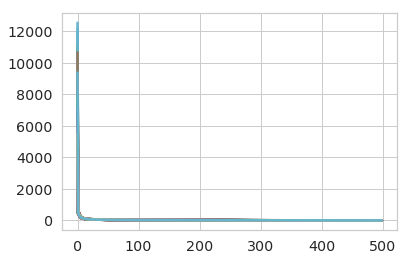

In [37]:
plt.plot(Rs_all[-1].T)

In [42]:
cumvar = np.cumsum(Rs_all[-1]**2,-1) / np.sum(Rs_all[-1]**2,-1,keepdims=True)

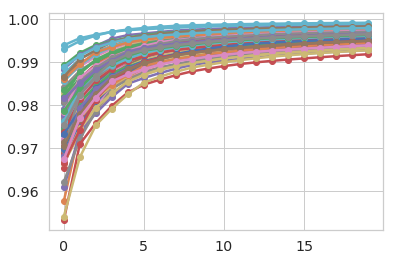

In [53]:
plt.plot(cumvar[:,:20].T, 'o-');
# plt.ylim([0,1.1])